In [19]:
import sys
sys.path.append("./../../src")
from visualizer_helper import Visualizer

import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn import preprocessing
from scipy.sparse import csr_matrix
import scipy
import pickle
import os
from annoy import AnnoyIndex
from scipy.sparse.linalg import inv
import hdbscan

large_file_path = "../../../large_data_files"

In [20]:
k_neighbors = 2000

In [21]:
A = pickle.load(open(os.path.join(large_file_path, "A_mknn_CLEANED_K{}_CSR.p".format(k_neighbors)), "rb"))

D = pickle.load(open("./data/D_mknn_K{}_CSR.p".format(k_neighbors), "rb"))
D_mc = pickle.load(open("./data/D_mc_mknn_K{}_CSR.p".format(k_neighbors), "rb"))

D_inv_sqrt = pickle.load(open("./data/D_mknn_inv_sqrt_K{}_CSR.p".format(k_neighbors), "rb"))
D_mc_inv_sqrt = pickle.load(open("./data/D_mc_mknn_inv_sqrt_K{}_CSR.p".format(k_neighbors), "rb"))

L = pickle.load(open("./../../../large_data_files/L_mknn_CLEANED_K{}_CSR.p".format(k_neighbors), "rb"))
L_mc = pickle.load(open("./../../../large_data_files/L_mc_mknn_CLEANED_K{}_CSR.p".format(k_neighbors), "rb"))

L_evals = pickle.load(open("./data/L_evals50_K{}.p".format(k_neighbors), "rb"))
L_evecs = pickle.load(open("./data/L_evecs50_K{}.p".format(k_neighbors), 'rb'))

L_mc_evals = pickle.load(open("./data/L_mc_evals50_K{}.p".format(k_neighbors), "rb"))
L_mc_evecs = pickle.load(open("./data/L_mc_evecs50_K{}.p".format(k_neighbors), "rb"))

[ 1.          0.99991231  0.95052413  0.92732507  0.88095456  0.87728565
  0.83915911  0.81860114  0.73231867  0.70231609  0.66675754  0.6429338
  0.63890823  0.6316124   0.61387586  0.58075722  0.57842257  0.55546628
  0.53703851  0.535545    0.52002377  0.51485354  0.50576566  0.5009185
  0.49427004  0.48824275  0.48168454  0.47259216  0.47177615  0.4610282
  0.45478224  0.44372593  0.44270537  0.44049677  0.43361816  0.42984515
  0.42544293  0.42036832  0.41595257  0.41397267  0.40940538  0.40803585
  0.40280271  0.40081272  0.39633623  0.3898325   0.38405978  0.38089607
  0.37806302 -0.39889951]
[0.87712187 0.71579848 0.56651473 0.47668165 0.41242267 0.36556714
 0.34860866 0.32741455 0.31552853 0.2983063  0.29582697 0.2848248
 0.25608884 0.24387348 0.2367467  0.23482489 0.22591445 0.21959907
 0.21927914 0.20502441 0.20236774 0.19267656 0.19214816 0.1801839
 0.17923318 0.17818994 0.1729461  0.17166205 0.16206203 0.16118392
 0.15969238 0.1563684  0.1551942  0.15169727 0.15082688 0.15

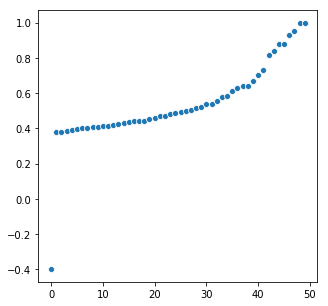

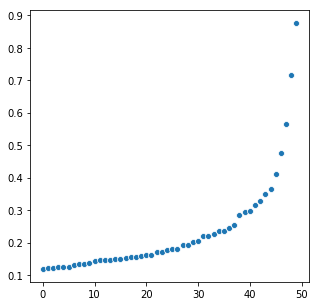

In [22]:
print(np.flip(L_evals))
plt.figure(figsize=(5,5))
ax = sns.scatterplot(range(L_evals.shape[0]), L_evals)

print(np.flip(L_mc_evals))
plt.figure(figsize=(5,5))
ax = sns.scatterplot(range(L_evals.shape[0]), L_mc_evals)

In [23]:
def get_evec_df(evecs, top_k_evecs=5):
    k_evecs = evecs[:, -top_k_evecs:]
    evec_cols = ["Evec_{}".format(i) for i in range(top_k_evecs)]
    evec_df = pd.DataFrame(k_evecs, columns=evec_cols)
    return evec_df

L_evecdf = get_evec_df(L_evecs, top_k_evecs=10)
L_mc_evecdf = get_evec_df(L_mc_evecs, top_k_evecs=10)

In [24]:
print(L_evecdf.describe())
print(L_mc_evecdf.describe())

             Evec_0        Evec_1        Evec_2        Evec_3        Evec_4  \
count  46498.000000  46498.000000  46498.000000  46498.000000  46498.000000   
mean       0.000217     -0.000311     -0.000281      0.000181     -0.000289   
std        0.004632      0.004627      0.004629      0.004634      0.004629   
min       -0.022598     -0.019345     -0.026834     -0.013992     -0.027660   
25%       -0.001401     -0.002259     -0.000635     -0.002041     -0.000027   
50%        0.000003     -0.000126      0.000942      0.000008      0.000008   
75%        0.002883      0.000731      0.002747      0.002300      0.000037   
max        0.014729      0.026853      0.007184      0.017834      0.024849   

             Evec_5        Evec_6        Evec_7        Evec_8        Evec_9  
count  4.649800e+04  46498.000000  46498.000000  46498.000000  46498.000000  
mean   1.957942e-05      0.001104     -0.000652     -0.001871      0.003785  
std    4.637497e-03      0.004504      0.004592      0

In [29]:
def get_Y(evecs, drop_k_evecs = 1, keep_top_k_evecs = 5):
    X_top_k = evecs[:, -drop_k_evecs-keep_top_k_evecs:-drop_k_evecs]
    evecs_lengths_top_k = np.linalg.norm(X_top_k, axis=1)
    Y_top_k = X_top_k / evecs_lengths_top_k[:, None]
    return Y_top_k

keep_k_evecs=8
drop_k_evecs=2
Y = get_Y(L_evecs, drop_k_evecs=drop_k_evecs, keep_top_k_evecs=keep_k_evecs)
Y_mc = get_Y(L_mc_evecs, drop_k_evecs=drop_k_evecs, keep_top_k_evecs=keep_k_evecs)

print(Y.shape, Y_mc.shape)

(46498, 8) (46498, 8)


In [32]:
visualizer = Visualizer()
lc=100

try:
    Y_umap_2d = pickle.load(open("./data/Y_umap_2d_K{}_topkevecs{}_drop{}_lc{}.p".format(k_neighbors, keep_k_evecs, drop_k_evecs, lc), 'rb'))
    Y_umap_3d = pickle.load(open("./data/Y_umap_3d_K{}_topkevecs{}_drop{}_lc{}.p".format(k_neighbors, keep_k_evecs, drop_k_evecs, lc), 'rb'))

    Y_mc_umap_2d = pickle.load(open("./data/Y_umap_2d_mc_K{}_topkevecs{}_drop{}_lc{}.p".format(k_neighbors, keep_k_evecs, drop_k_evecs, lc), 'rb'))
    Y_mc_umap_3d = pickle.load(open("./data/Y_umap_3d_mc_K{}_topkevecs{}_drop{}_lc{}.p".format(k_neighbors, keep_k_evecs, drop_k_evecs, lc), 'rb'))
except FileNotFoundError:
    print("Error: 1 or more umap files not found")
    Y_umap_2d = visualizer.umap_embedding(Y, n_components=2, lc=lc)
    Y_umap_3d = visualizer.umap_embedding(Y, n_components=3, lc=lc)
    
    Y_mc_umap_2d = visualizer.umap_embedding(Y_mc, n_components=2, lc=lc)
    Y_mc_umap_3d = visualizer.umap_embedding(Y_mc, n_components=3, lc=lc)

    pickle.dump(Y_umap_2d, open("./data/Y_umap_2d_K{}_topkevecs{}_drop{}_lc{}.p".format(k_neighbors, keep_k_evecs, drop_k_evecs, lc), 'wb'))
    pickle.dump(Y_umap_3d, open("./data/Y_umap_3d_K{}_topkevecs{}_drop{}_lc{}.p".format(k_neighbors, keep_k_evecs, drop_k_evecs, lc), 'wb'))

    pickle.dump(Y_mc_umap_2d, open("./data/Y_umap_2d_mc_K{}_topkevecs{}_drop{}_lc{}.p".format(k_neighbors, keep_k_evecs, drop_k_evecs, lc), 'wb'))
    pickle.dump(Y_mc_umap_3d, open("./data/Y_umap_3d_mc_K{}_topkevecs{}_drop{}_lc{}.p".format(k_neighbors, keep_k_evecs, drop_k_evecs, lc), 'wb'))

Error: 1 or more umap files not found


./../../src/visualizer_helper.py:22: UserWarning: Parameter should_downcast is deprecated, use convert_dtype in fit, fit_transform and transform  methods instead. 
  return UMAP(n_components=n_components, local_connectivity=lc).fit_transform(X)
./../../src/visualizer_helper.py:22: UserWarning: Parameter should_downcast is deprecated, use convert_dtype in fit, fit_transform and transform  methods instead. 
  return UMAP(n_components=n_components, local_connectivity=lc).fit_transform(X)


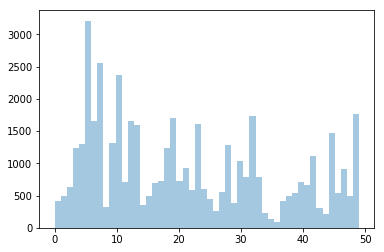

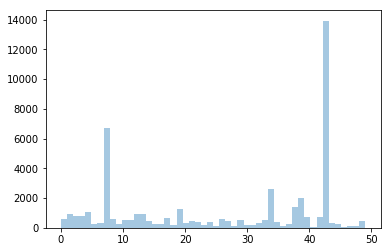

In [33]:
knn_clusters = 50

try:
    Y_cluster_labels = pickle.load(open("./data/cluster_labels_K{}_knn{}_topkevecs{}_drop{}.p".format(k_neighbors, knn_clusters, keep_k_evecs, drop_k_evecs), 'rb'))
    Y_mc_cluster_labels = pickle.load(open("./data/cluster_labels_mc_K{}_knn{}_topkevecs{}_drop{}.p".format(k_neighbors, knn_clusters, keep_k_evecs, drop_k_evecs), 'rb'))
except FileNotFoundError:
    print("running Kmeans")
    
    Y_kmeans = KMeans(n_clusters=knn_clusters).fit(Y)
    Y_mc_kmeans = KMeans(n_clusters=knn_clusters).fit(Y_mc)

    Y_cluster_labels = Y_kmeans.labels_    
    Y_mc_cluster_labels = Y_mc_kmeans.labels_

    pickle.dump(Y_cluster_labels, open("./data/cluster_labels_K{}_knn{}_topkevecs{}_drop{}.p".format(k_neighbors, knn_clusters, keep_k_evecs, drop_k_evecs), "wb"))
    pickle.dump(Y_mc_cluster_labels, open("./data/cluster_labels_mc_K{}_knn{}_topkevecs{}_drop{}.p".format(k_neighbors, knn_clusters, keep_k_evecs, drop_k_evecs), "wb"))

    print("Cluster labels:", np.unique(Y_cluster_labels))
    
plt.figure()
sns.distplot(Y_cluster_labels, bins=knn_clusters, kde=False)
plt.figure()
sns.distplot(Y_mc_cluster_labels, bins=knn_clusters, kde=False)

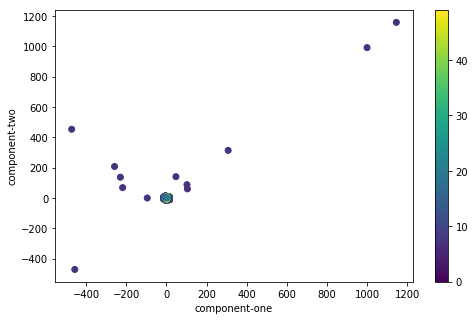

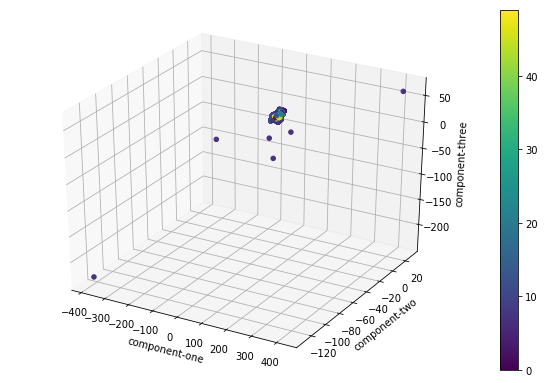

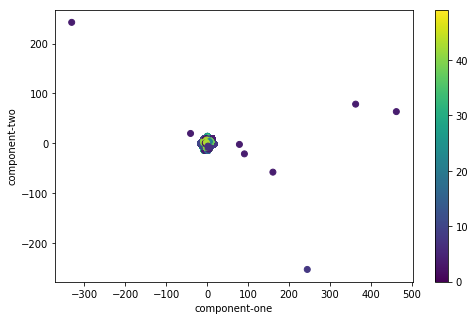

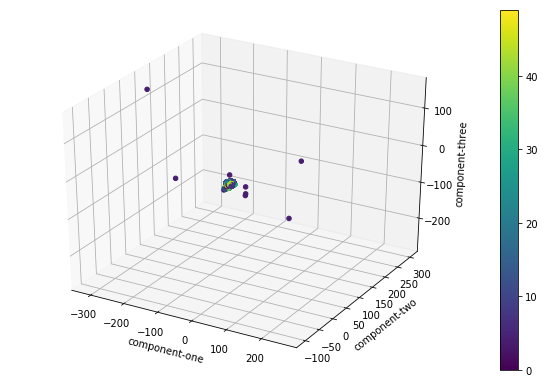

In [34]:
alpha = 1

filename_2d = "./figures/umap2d_K{}_topkevecs{}_knn{}".format(k_neighbors, keep_k_evecs, knn_clusters)
filename_3d = "./figures/umap3d_K{}_topkevecs{}_knn{}".format(k_neighbors, keep_k_evecs, knn_clusters)   

filename_mc_2d = "./figures/umap2d_mc_K{}_topkevecs{}_knn{}".format(k_neighbors, keep_k_evecs, knn_clusters)
filename_mc_3d = "./figures/umap3d_mc_K{}_topkevecs{}_knn{}".format(k_neighbors, keep_k_evecs, knn_clusters)

visualizer.plot2d(
    X=Y_umap_2d, 
    filename=filename_2d, 
    colors=Y_cluster_labels,
    alpha = alpha
)

visualizer.plot3d(
    X=Y_umap_3d, 
    filename=filename_3d, 
    colors=Y_cluster_labels,
    alpha = alpha
)

visualizer.plot2d(
    X=Y_mc_umap_2d, 
    filename=filename_mc_2d, 
    colors=Y_mc_cluster_labels,
    alpha = alpha
)
visualizer.plot3d(
    X=Y_mc_umap_3d, 
    filename=filename_mc_3d, 
    colors=Y_mc_cluster_labels,
    alpha = alpha
)

In [35]:
def sort_by_cluster_membership(M, cluster_labels):
    sorted_cluster_labels = sorted(list(enumerate(cluster_labels.tolist())), key=lambda p: p[1])
    clusters_by_idx = [p[0] for p in sorted_cluster_labels]
    return M[clusters_by_idx][:, clusters_by_idx]

L_sorted = sort_by_cluster_membership(L, Y_cluster_labels)
L_mc_sorted = sort_by_cluster_membership(L_mc, Y_mc_cluster_labels)

A_sorted = sort_by_cluster_membership(A, Y_cluster_labels)
A_mc_sorted = sort_by_cluster_membership(A, Y_mc_cluster_labels)

print(L_sorted.shape, A_sorted.shape, L_mc_sorted.shape, A_mc_sorted.shape)

(46498, 46498) (46498, 46498) (46498, 46498) (46498, 46498)


MemoryError: Unable to allocate array with shape (400040001, 2) and data type int64

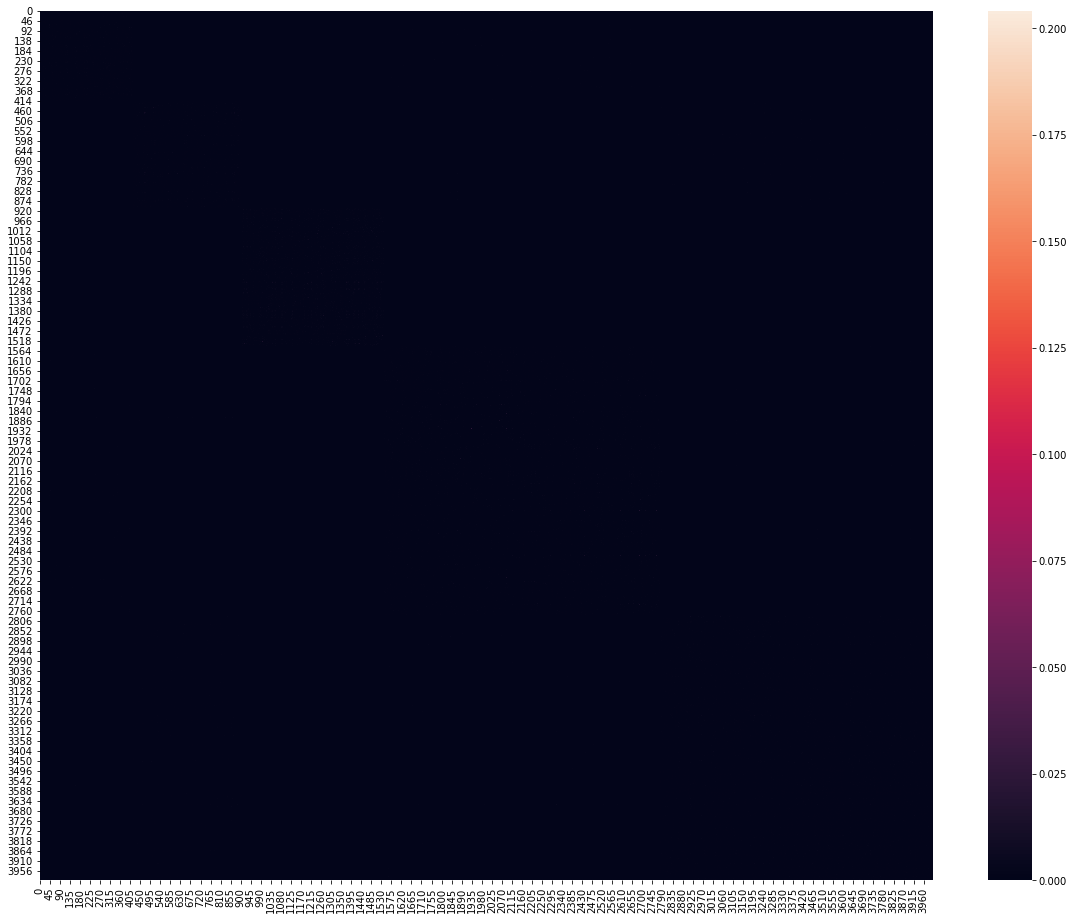

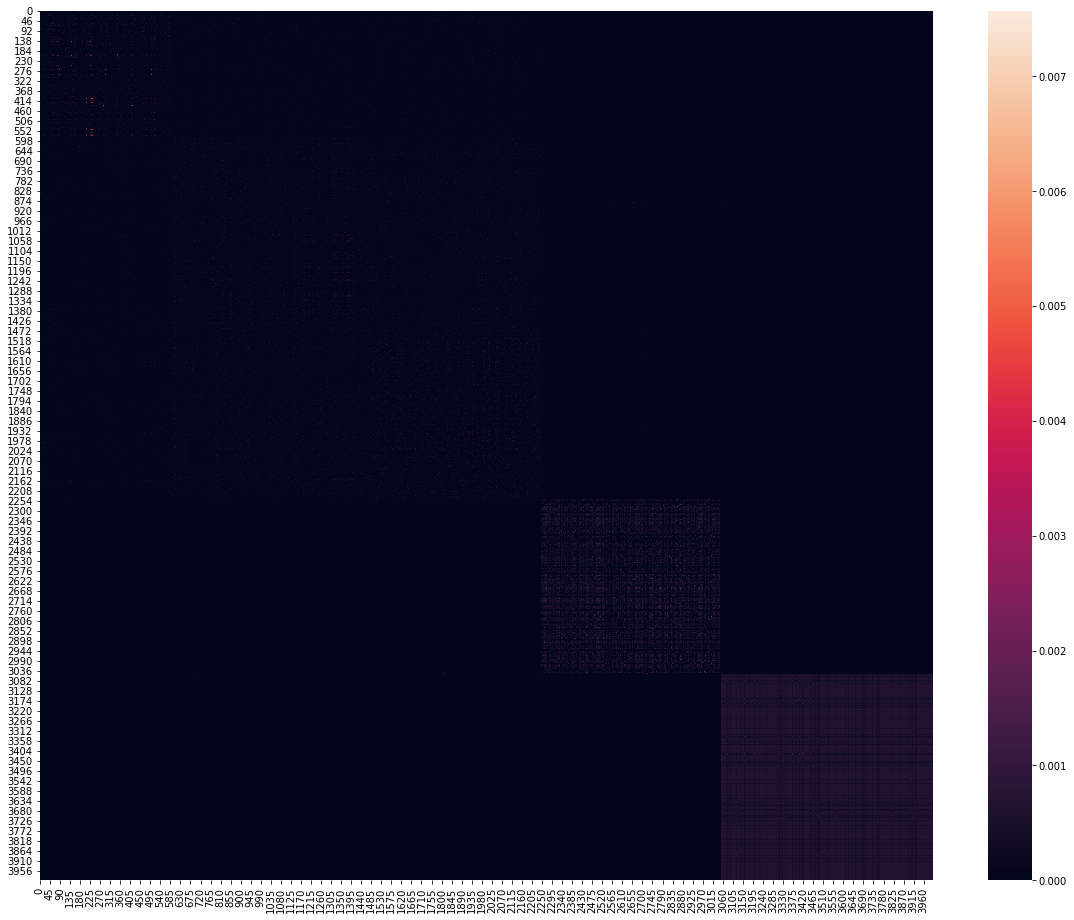

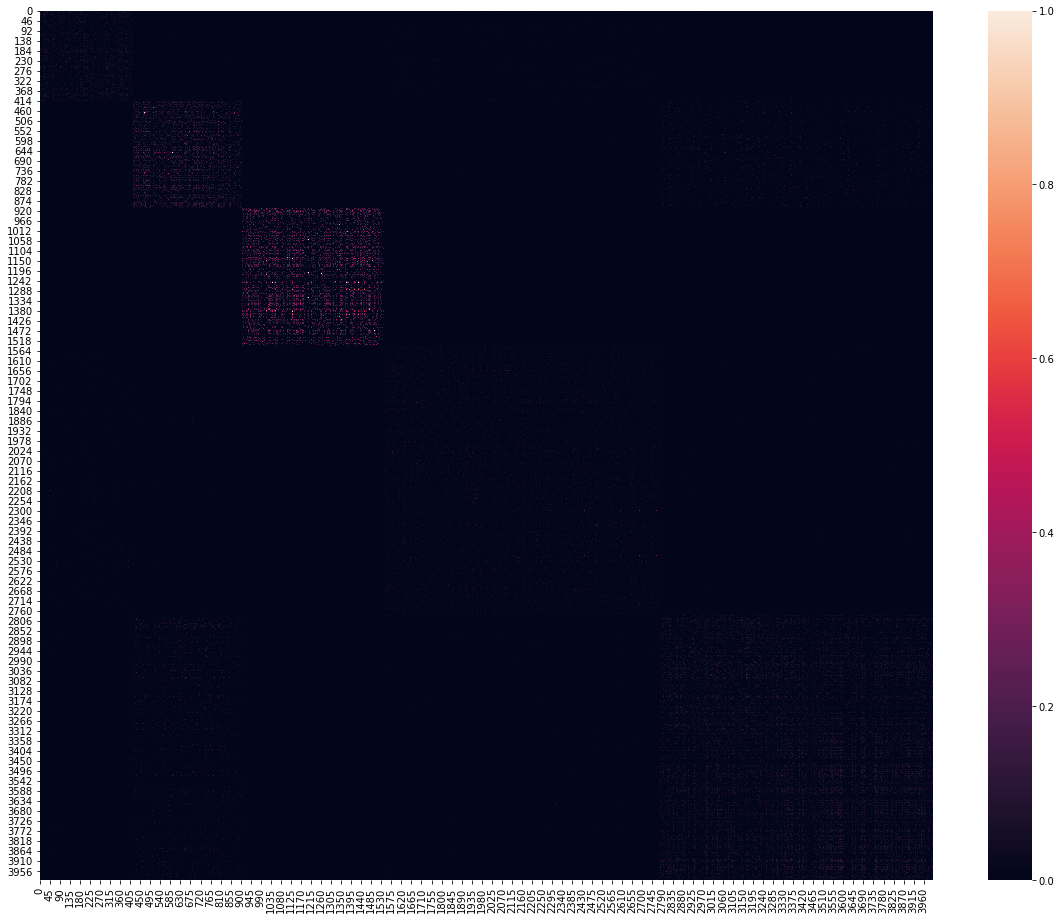

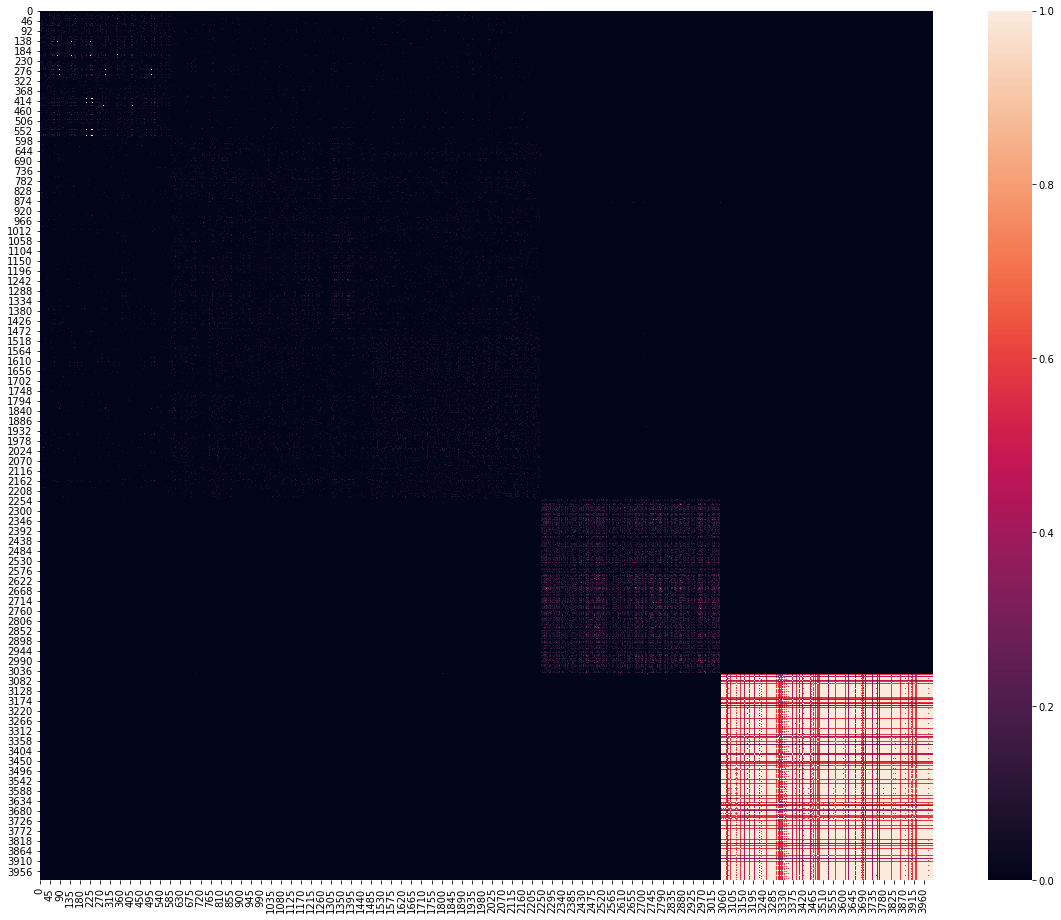

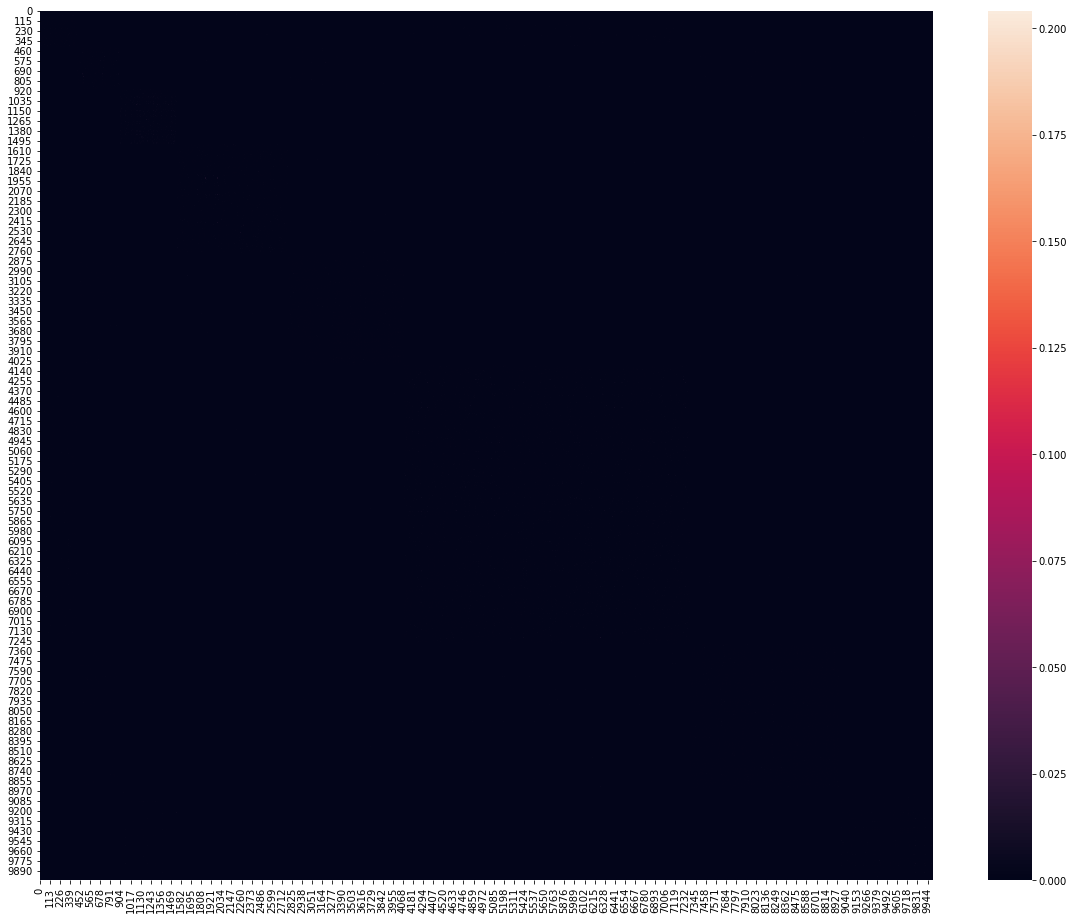

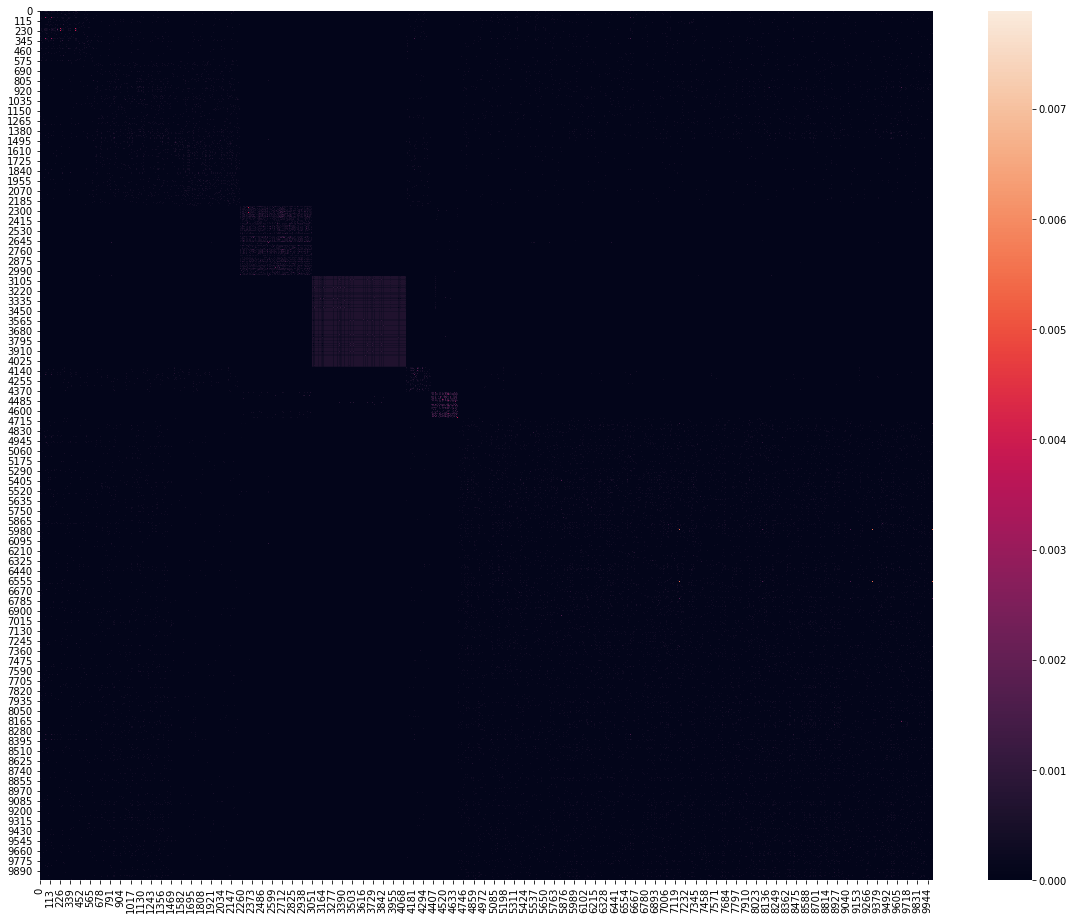

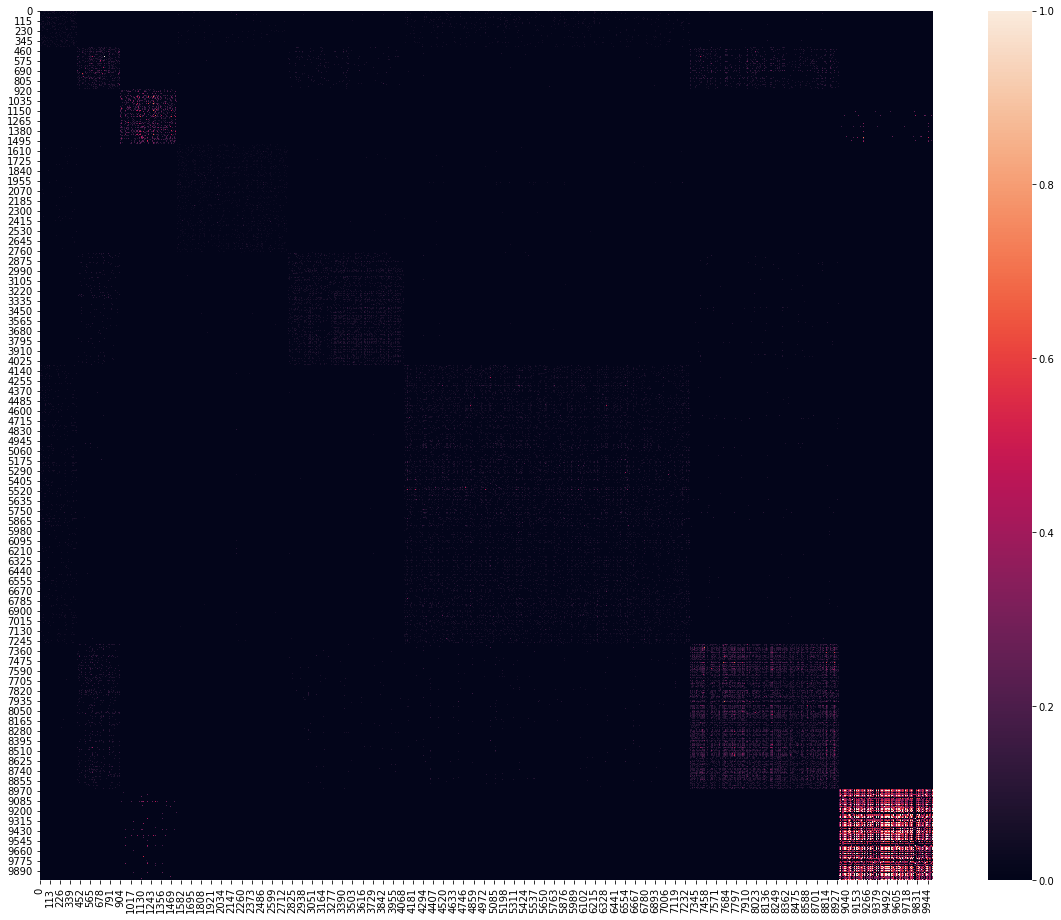

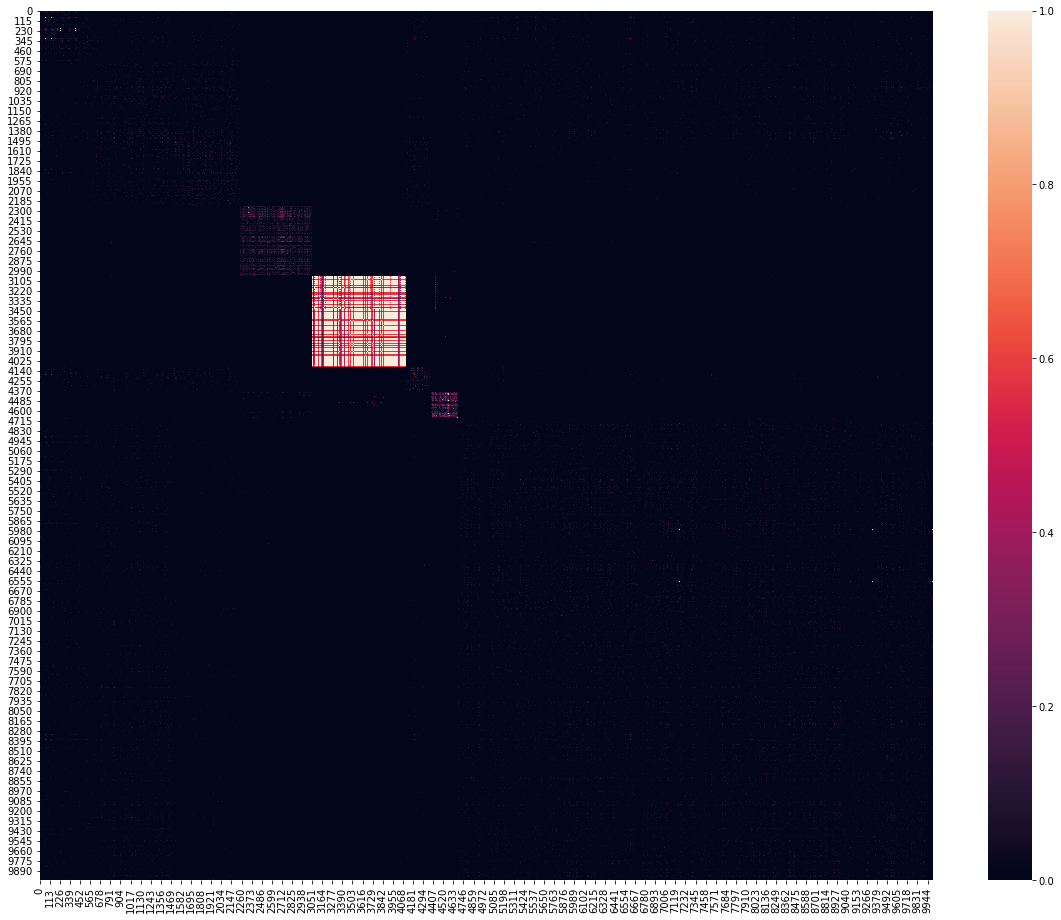

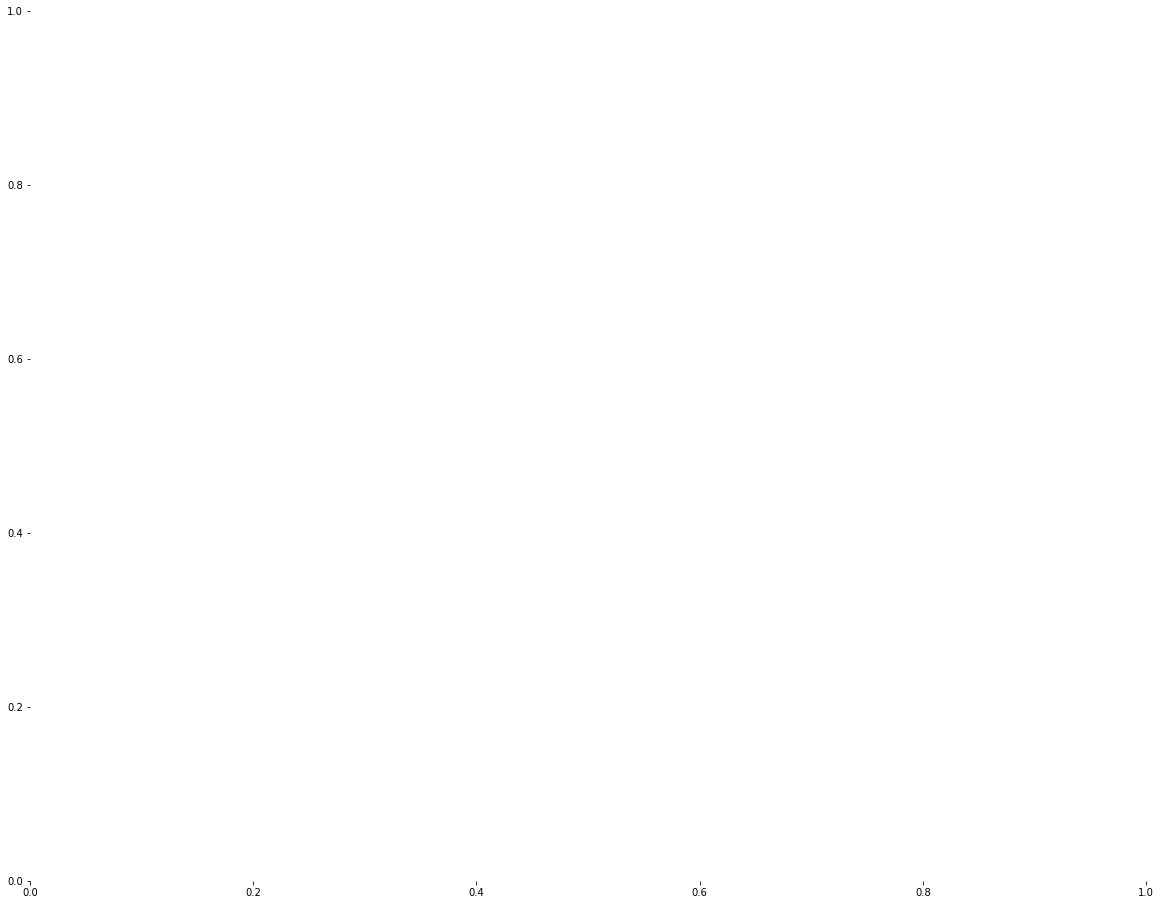

In [36]:
# sns.heatmap(L_sorted[:100, :100].toarray())
plot_dims = [4000, 10000, 20000]
plot_vars = [L_sorted, L_mc_sorted, A_sorted, A_mc_sorted]
plot_var_names = ['L_sorted', 'L_mc_sorted', 'A_sorted', 'A_mc_sorted']
for dim in plot_dims:
    for v in range(len(plot_vars)):
        var = plot_vars[v]
        varname = plot_var_names[v]
        
        plt.figure(figsize=(20,16))
        sns.heatmap((var[:dim, :dim]).toarray())
        plt.savefig("./figures/heatmap_{}_knn{}_kevecs{}_{}x{}.png".format(varname, knn_clusters, keep_k_evecs, dim, dim))

In [ ]:
sns.distplot(Y_cluster_labels, bins=knn_clusters)

In [ ]:
sns.distplot(Y_mc_cluster_labels, bins=knn_clusters)